In [177]:
!python -V

Python 3.9.13


In [178]:
import os
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, Dense, Dropout, Conv1D, Flatten, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import mlflow
import mlflow.sklearn
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

In [179]:
# Set MLflow experiment name
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name='Pamen_DL_GWL_experiment')


<Experiment: artifact_location='file:///D:/RGT/Code/Practice/Deep Learning for GWL Changes/mlruns/1', creation_time=1705882608650, experiment_id='1', last_update_time=1705882608650, lifecycle_stage='active', name='Pamen_DL_GWL_experiment', tags={}>

In [180]:
pamen_url = r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Pamen.csv"
nsawam_url = r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv"
suhum_url = r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Suhum.csv"

In [181]:
pamen_data = pd.read_csv(pamen_url)
nsawam_data = pd.read_csv(nsawam_url)
suhum_data = pd.read_csv(suhum_url)

In [182]:
data = pd.concat([pamen_data, nsawam_data, suhum_data], ignore_index=True)
data

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,19.71,27.26,14.89,68.69,0.00,1.49,0.52,379.60,407.0
1,19.67,27.22,14.34,67.00,0.00,1.40,0.52,401.30,407.0
2,20.42,27.65,14.53,66.56,0.00,1.73,0.52,405.50,406.7
3,19.79,27.52,15.01,68.06,0.00,1.23,0.52,397.90,406.9
4,19.24,27.79,14.89,66.75,0.00,1.33,0.52,384.90,406.5
...,...,...,...,...,...,...,...,...,...
12049,20.87,25.16,10.99,58.94,0.01,1.03,0.53,348.78,483.3
12050,19.13,26.98,15.14,70.81,0.10,0.90,0.53,372.94,484.8
12051,19.32,26.48,13.98,67.69,0.02,0.71,0.52,366.63,487.5
12052,18.44,26.44,15.08,72.88,0.03,1.38,0.52,367.59,484.8


In [183]:
data.describe()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
count,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000,12054.000000
mean,17.755979,25.923559,16.623152,80.338824,3.265281,1.693207,0.589813,408.717311,390.981193
std,3.255272,1.609702,1.620285,9.145783,4.096165,0.492936,0.087118,10.955587,81.282748
min,2.460000,20.590000,4.460000,24.120000,0.000000,0.520000,0.450000,340.440000,125.900000
25%,16.020000,24.690000,15.990000,75.440000,0.550000,1.340000,0.520000,403.732500,355.500000
50%,18.140000,25.830000,16.850000,82.560000,1.970000,1.640000,0.590000,409.700000,405.300000
75%,19.940000,27.070000,17.640000,87.250000,4.410000,2.010000,0.650000,415.100000,439.500000
max,26.550000,31.960000,20.080000,95.250000,66.020000,3.990000,0.880000,444.700000,500.000000


In [184]:
data.isnull().sum()

Sunlight         0
Avg_Temp         0
Spec_Hum         0
Rel_Hum          0
Precipitation    0
Wind_Speed       0
Soil_Moisture    0
Rainfall         0
GWL              0
dtype: int64

In [185]:
data.head(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,19.71,27.26,14.89,68.69,0.00,1.49,0.52,379.6,407.0
1,19.67,27.22,14.34,67.00,0.00,1.40,0.52,401.3,407.0
2,20.42,27.65,14.53,66.56,0.00,1.73,0.52,405.5,406.7
3,19.79,27.52,15.01,68.06,0.00,1.23,0.52,397.9,406.9
4,19.24,27.79,14.89,66.75,0.00,1.33,0.52,384.9,406.5
5,18.97,27.30,15.56,69.88,0.05,1.54,0.51,394.7,407.0
6,18.95,26.97,15.81,72.19,0.03,1.41,0.51,411.8,406.9
7,18.41,26.87,14.22,67.12,0.06,1.57,0.51,407.3,406.3
8,20.55,27.12,13.55,64.31,0.05,0.81,0.51,390.4,406.6
9,17.65,27.30,12.51,59.31,0.10,1.35,0.50,403.3,406.4


In [186]:
data.tail(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
12044,18.81,26.92,16.91,77.56,0.15,0.94,0.54,396.07,480.3
12045,17.73,26.43,17.09,79.75,0.12,1.02,0.54,393.32,480.7
12046,19.32,27.60,15.69,70.56,0.12,0.83,0.54,393.20,480.2
12047,19.15,27.44,14.47,66.44,0.12,0.98,0.54,392.55,481.1
12048,20.09,26.15,12.27,61.75,0.03,1.69,0.53,364.95,481.0
12049,20.87,25.16,10.99,58.94,0.01,1.03,0.53,348.78,483.3
12050,19.13,26.98,15.14,70.81,0.10,0.90,0.53,372.94,484.8
12051,19.32,26.48,13.98,67.69,0.02,0.71,0.52,366.63,487.5
12052,18.44,26.44,15.08,72.88,0.03,1.38,0.52,367.59,484.8
12053,16.70,26.47,14.10,69.00,0.01,0.59,0.52,364.47,483.9


In [187]:
data = data.astype('float32')

In [188]:
data.head()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,19.709999,27.260000,14.89,68.690002,0.0,1.49,0.52,379.600006,407.000000
1,19.670000,27.219999,14.34,67.000000,0.0,1.40,0.52,401.299988,407.000000
2,20.420000,27.650000,14.53,66.559998,0.0,1.73,0.52,405.500000,406.700012
3,19.790001,27.520000,15.01,68.059998,0.0,1.23,0.52,397.899994,406.899994
4,19.240000,27.790001,14.89,66.750000,0.0,1.33,0.52,384.899994,406.500000


In [189]:
corr_matrix = data.corr()['GWL']
print(corr_matrix)

Sunlight        -0.004743
Avg_Temp        -0.014815
Spec_Hum        -0.038806
Rel_Hum         -0.029295
Precipitation    0.010260
Wind_Speed       0.092492
Soil_Moisture   -0.010908
Rainfall        -0.084212
GWL              1.000000
Name: GWL, dtype: float64


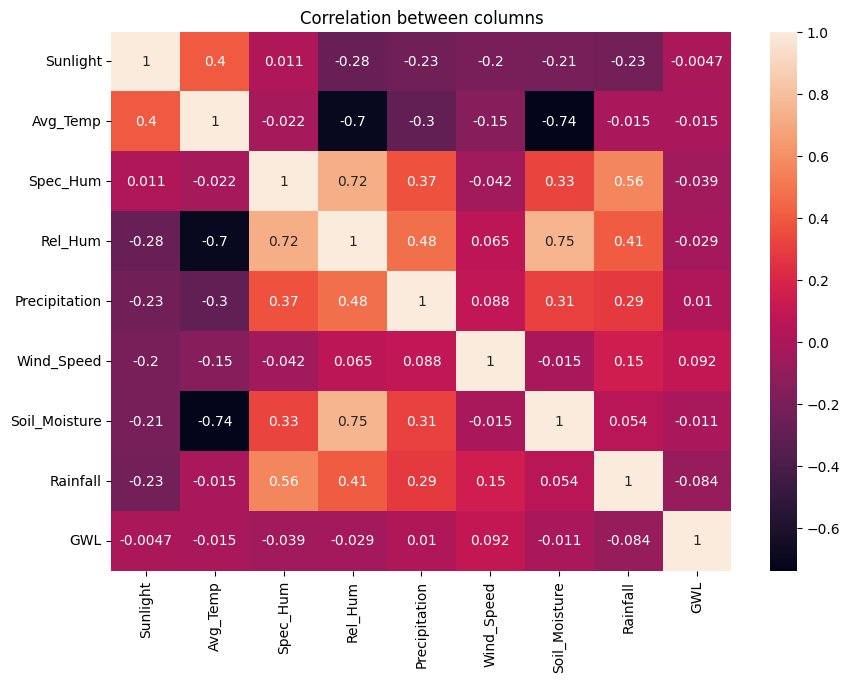

In [190]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation between columns')
plt.show()

# Lighter color -> higher correlation value
# Darker color -> lower correlation value

In [191]:
x = data.drop(columns = 'GWL')
x

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall
0,19.709999,27.260000,14.89,68.690002,0.00,1.49,0.52,379.600006
1,19.670000,27.219999,14.34,67.000000,0.00,1.40,0.52,401.299988
2,20.420000,27.650000,14.53,66.559998,0.00,1.73,0.52,405.500000
3,19.790001,27.520000,15.01,68.059998,0.00,1.23,0.52,397.899994
4,19.240000,27.790001,14.89,66.750000,0.00,1.33,0.52,384.899994
...,...,...,...,...,...,...,...,...
12049,20.870001,25.160000,10.99,58.939999,0.01,1.03,0.53,348.779999
12050,19.129999,26.980000,15.14,70.809998,0.10,0.90,0.53,372.940002
12051,19.320000,26.480000,13.98,67.690002,0.02,0.71,0.52,366.630005
12052,18.440001,26.440001,15.08,72.879997,0.03,1.38,0.52,367.589996


In [192]:
y = data['GWL']
y

0        407.000000
1        407.000000
2        406.700012
3        406.899994
4        406.500000
            ...    
12049    483.299988
12050    484.799988
12051    487.500000
12052    484.799988
12053    483.899994
Name: GWL, Length: 12054, dtype: float32

In [193]:
data.shape

(12054, 9)

In [194]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 42)

In [195]:
x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size = 0.5, random_state = 42)

In [196]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('x_val', x_val.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

x_train (10245, 8)
x_test (5122, 8)
x_val (5123, 8)
y_train (10245,)
y_test (5122,)
y_val (5123,)


In [197]:
# Scaling data into numpy arrays
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [198]:
x_train

array([[-0.44415218, -0.23122518,  1.003544  , ..., -1.7313735 ,
         1.8350824 ,  0.0793009 ],
       [-0.31837076,  1.7390333 , -3.1885197 , ..., -0.39073238,
        -1.2628666 , -0.13345982],
       [ 0.35348642, -0.7906043 , -0.05374582, ...,  0.80771947,
         0.8024331 ,  0.32025048],
       ...,
       [-2.4842658 , -1.064079  ,  0.13792638, ..., -0.53292173,
         0.45821616,  0.65666586],
       [ 0.05590612,  0.47732285,  0.96644646, ...,  2.5139904 ,
        -0.45969442,  1.9295954 ],
       [ 0.32587582, -0.70358896,  0.7376755 , ..., -0.8782383 ,
         1.4908662 ,  0.04020445]], dtype=float32)

In [199]:
x_test

array([[-2.3768914e+00, -9.8949456e-01,  4.7799006e-01, ...,
        -2.0791760e-01,  1.0319105e+00, -1.5619071e-01],
       [ 6.8481314e-01, -6.7872828e-01, -2.1312292e+00, ...,
        -1.4697942e-01,  6.8769366e-01, -3.3594251e+00],
       [-2.9689538e-01, -5.4820579e-01, -5.3745817e-02, ...,
         1.1124109e+00, -4.5969442e-01,  1.0658218e+00],
       ...,
       [-7.2943188e-02,  5.2082998e-01, -2.8251678e-01, ...,
        -3.7041965e-01, -3.4495568e-01, -7.0722371e-02],
       [ 1.3658735e+00,  1.0056258e+00,  8.5515255e-01, ...,
         9.0928358e-01, -7.3945383e-04, -5.6625396e-01],
       [-1.2049764e+00, -1.8285639e+00, -5.7930040e-01, ...,
         1.1530364e+00,  1.8350824e+00, -2.9621094e-01]], dtype=float32)

In [200]:
x_val

array([[-1.6252705 , -1.0578636 ,  0.09464568, ...,  0.97022176,
         0.9171718 ,  0.50209755],
       [-1.557778  ,  0.2597862 ,  0.589284  , ..., -0.39073238,
        -0.57443315,  2.0932593 ],
       [-0.24474266, -0.4549761 , -0.9193641 , ...,  3.021809  ,
        -0.8039113 ,  0.70212764],
       ...,
       [ 1.5622157 ,  1.9068474 ,  0.85515255, ...,  0.5233413 ,
        -1.492344  ,  0.01110825],
       [ 1.1971425 ,  1.3847599 ,  0.51508766, ..., -0.14697942,
        -1.2628666 ,  0.23841709],
       [-3.0886304 , -0.57306767,  0.8922501 , ...,  0.09677355,
         0.68769366,  1.1531076 ]], dtype=float32)

In [201]:
print(x_train.shape[1])

epochs = 2000
batch_size = 100
patience = 100

8


### 1. Feed-Forward Neural Network

2024/01/26 22:27:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpccu2whsy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpccu2whsy\model\data\model\assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1000)              9000      
                                                                 
 dense_37 (Dense)            (None, 500)               500500    
                                                                 
 dense_38 (Dense)            (None, 250)               125250    
                                                                 
 dense_39 (Dense)            (None, 1)                 251       
                                                                 
Total params: 635001 (2.42 MB)
Trainable params: 635001 (2.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
103/103 [==============================] - 1s 8ms/step - loss: 21345.8125 - mae: 108.2262 - val_loss: 9892.3945 - val_mae: 75.1104
Epoch

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\_ffn_saved_model\assets


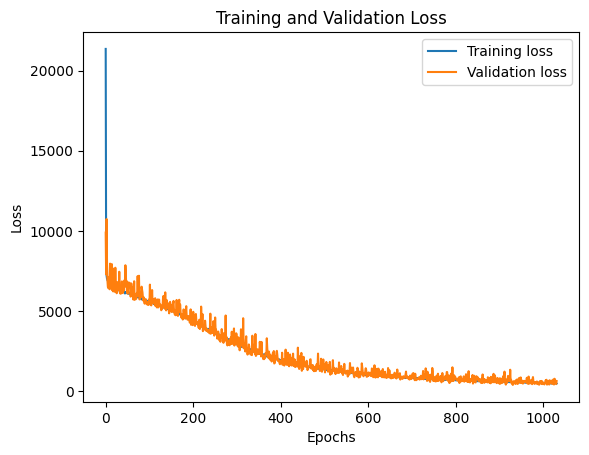

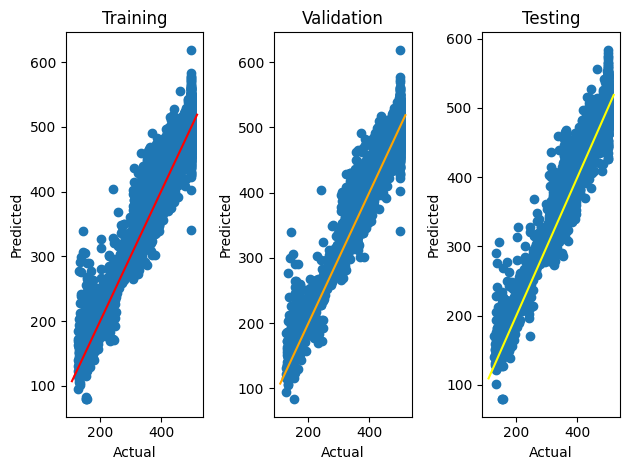

In [202]:
# Start MLflow run
with mlflow.start_run():
    
    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "feedforward_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)
     
    # Feed forward neural network model architecture
    ffn_model = Sequential()
    ffn_model.add(Input(shape=(x_train.shape[1],)))
    ffn_model.add(Dense(1000, activation='relu'))
    ffn_model.add(Dense(500, activation='relu'))
    ffn_model.add(Dense(250, activation='linear'))
    ffn_model.add(Dense(1, activation='linear'))
    
    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(ffn_model, 'ffn_model')
    ffn_model.summary()

    # Define your model
    ffn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=patience)


    # Train the model
    history = ffn_model.fit(x_train, y_train,
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val, y_val),
                            verbose=1)

    # Log final metrics
    mlflow.log_metric("final_training_loss", history.history['loss'][-1])
    mlflow.log_metric("final_validation_loss", history.history['val_loss'][-1])

    # Predictions
    train_preds = ffn_model.predict(x_train)
    val_preds = ffn_model.predict(x_val)
    test_preds = ffn_model.predict(x_test)

    # Evaluation on test set
    ffn_results = ffn_model.evaluate(x_test, y_test)
    
    # MAE
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    test_mae = ffn_results[1]
    
    # MSE
    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    test_mse = ffn_results[0]
    
    # RMSE
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)
    
    # R-Square
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    # MAPE
    train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100
    
    # Logging metrics
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("test_mae", test_mae)

    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("test_mse", test_mse)

    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("test_rmse", test_rmse)

    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_metric("test_r2", test_r2)

    mlflow.log_metric("train_mape", train_mape)
    mlflow.log_metric("val_mape", val_mape)
    mlflow.log_metric("test_mape", test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    #Directory to save the plot
    plot_directory = "D:\\RGT\\Code\\Practice\\Deep Learning for GWL Changes\\Artifacts"
    os.makedirs(plot_directory, exist_ok=True)  
    
    loss_plot_path = os.path.join(plot_directory, "_ffn_loss_plot.png")
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()

    # Save scatter plot
    scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\_ffn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)

    # Print results
    print(" ")
    print("Training Results:")
    print("Train MAE:", train_mae)
    print("Train MSE:", train_mse)
    print("Train RMSE:", train_rmse)
    print("Train MAPE:", train_mape)
    print("Train R-squared:", train_r2)

    print(" ")
    print("Validation Results:")
    print("Validation MAE:", val_mae)
    print("Validation MSE:", val_mse)
    print("Validation RMSE:", val_rmse)
    print("Validation MAPE:", val_mape)
    print("Validation R-squared:", val_r2)

    print(" ")
    print("Testing Results:")
    print("Test MAE:", test_mae)
    print("Test MSE:", test_mse)
    print("Test RMSE:", test_rmse)
    print("Test MAPE:", test_mape)
    print("Test R-squared:", test_r2)
    
    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\_ffn_saved_model'
    ffn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)
    
    mlflow.end_run()


### 2. Convolutional Neural Network

In [203]:
# Reshape data for CNN 
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train_cnn.shape)

x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(x_val_cnn.shape)

x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test_cnn.shape)

(10245, 8, 1)
(5123, 8, 1)
(5122, 8, 1)


2024/01/26 22:44:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp17q_32ta\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp17q_32ta\model\data\model\assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 1024)           4096      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 1024)           0         
 g1D)                                                            
                                                                 
 dense_40 (Dense)            (None, 3, 256)            262400    
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                49216     
                                                                 
 dense_42 (Dense)            (None, 1)                 65        
                                                     

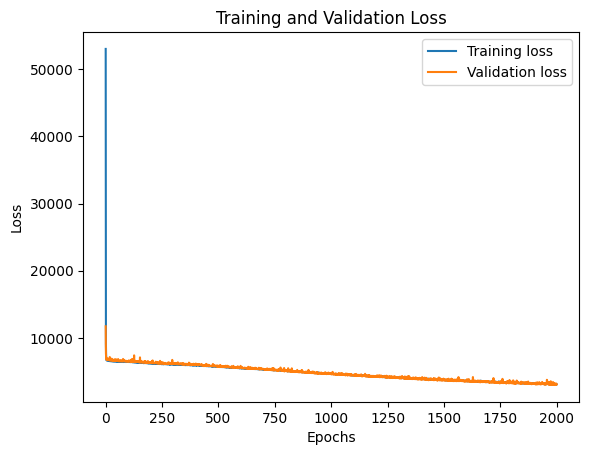

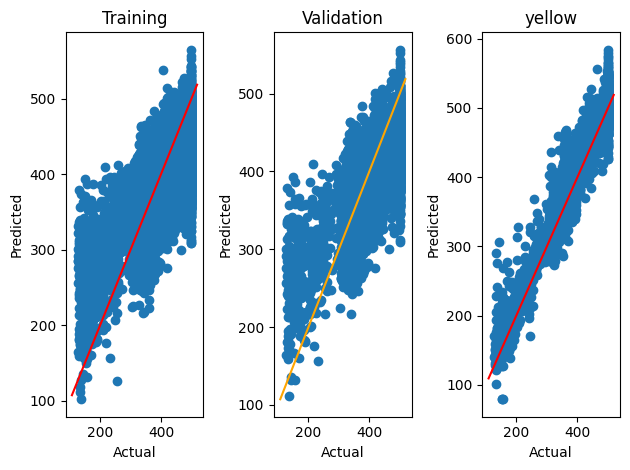

Training Results:
Train MAE: 41.75445
Train MSE: 2978.4712
Train RMSE: 54.57537
Train MAPE: 12.537235021591187
Train R-squared: 0.5491064332356346
 
Validation Results:
Validation MAE: 42.470165
Validation MSE: 3090.1003
Validation RMSE: 55.588673
Validation MAPE: 12.855318188667297
Validation R-squared: 0.544607039119252
 
Testing Results:
Test MAE: 41.03860092163086
Test MSE: 2866.819580078125
Test RMSE: 53.54268932429641
Test MAPE: 12.219089269638062
Test R-squared: 0.5538390328678704
INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\cnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\cnn_saved_model\assets


In [204]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "convolutional_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Pamen.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)
    
    #Convolutional neural network model architecture
    cnn_model = Sequential()
    cnn_model.add(Conv1D(1024, 3, activation="relu", input_shape=(x_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dense(1, activation='linear'))
    
    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(cnn_model, 'cnn_model')
    
    cnn_model.summary()
    
    cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = cnn_model.fit(x_train_cnn, y_train, 
              		    epochs=epochs,
               		    callbacks=[earlyStop],
               		    batch_size=batch_size,
               		    validation_data=(x_val_cnn, y_val),
               		    verbose=1)
    # Log metrics
    mlflow.log_metric('final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('final_validation_loss', history.history['val_loss'][-1])
    
    # Predictions
    train_preds = cnn_model.predict(x_train_cnn)
    val_preds = cnn_model.predict(x_val_cnn)
    test_preds = cnn_model.predict(x_test_cnn)
    
    # Evaluate on test set
    cnn_results = cnn_model.evaluate(x_test_cnn, y_test)
    
    # Mean Absolute Error (MAE)
    cnn_train_mae = mean_absolute_error(y_train, train_preds)
    cnn_val_mae = mean_absolute_error(y_val, val_preds)
    cnn_test_mae = cnn_results[1]
    
    # Mean Square Error (MAE)
    cnn_train_mse = mean_squared_error(y_train, train_preds)
    cnn_val_mse = mean_squared_error(y_val, val_preds)
    cnn_test_mse = cnn_results[0]
    
    # Root Mean Squared Error 
    cnn_train_rmse = np.sqrt(cnn_train_mse)
    cnn_val_rmse = np.sqrt(cnn_val_mse)
    cnn_test_rmse = np.sqrt(cnn_test_mse)
    
    # R-Squared
    cnn_train_r2 = r2_score(y_train, train_preds)
    cnn_val_r2 = r2_score(y_val, val_preds)
    cnn_test_r2 = r2_score(y_test, test_preds)
    
    # Mean Absolute Percentage Error
    cnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    cnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    cnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100
    
    # Logging metrics
    mlflow.log_metric('cnn_train_mae', cnn_train_mae)
    mlflow.log_metric('cnn_val_mae', cnn_val_mae)
    mlflow.log_metric('cnn_test_mae', cnn_test_mae)

    mlflow.log_metric('cnn_train_mse', cnn_train_mse)
    mlflow.log_metric('cnn_val_mse', cnn_val_mse)
    mlflow.log_metric('cnn_test_mse', cnn_test_mse)
    
    mlflow.log_metric("cnn_train_rmse", cnn_train_rmse)
    mlflow.log_metric("cnn_val_rmse", cnn_val_rmse)
    mlflow.log_metric("cnn_test_rmse", cnn_test_rmse)

    mlflow.log_metric("cnn_train_r2", cnn_train_r2)
    mlflow.log_metric("cnn_val_r2", cnn_val_r2)
    mlflow.log_metric("cnn_test_r2", cnn_test_r2)
    
    mlflow.log_metric("cnn_train_mape", cnn_train_mape)
    mlflow.log_metric("cnn_val_mape", cnn_val_mape)
    mlflow.log_metric("cnn_test_mape", cnn_test_mape)
    
    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    loss_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\cnn_loss_plot.png'
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)
    
    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("yellow")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='red')

    # Tight layout
    fig.tight_layout()

    # Save scatter plot
    scatter_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\cnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)
    plt.show()
    
    # Print results
    print("Training Results:")
    print("Train MAE:", cnn_train_mae)
    print("Train MSE:", cnn_train_mse)
    print("Train RMSE:", cnn_train_rmse)
    print("Train MAPE:", cnn_train_mape)
    print("Train R-squared:", cnn_train_r2)

    print(" ")
    print("Validation Results:")
    print("Validation MAE:", cnn_val_mae)
    print("Validation MSE:", cnn_val_mse)
    print("Validation RMSE:", cnn_val_rmse)
    print("Validation MAPE:", cnn_val_mape)
    print("Validation R-squared:", cnn_val_r2)

    print(" ")
    print("Testing Results:")
    print("Test MAE:", cnn_test_mae)
    print("Test MSE:", cnn_test_mse)
    print("Test RMSE:", cnn_test_rmse)
    print("Test MAPE:", cnn_test_mape)
    print("Test R-squared:", cnn_test_r2)
    
    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\cnn_saved_model'
    cnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)
    
    # End the MLflow run
    mlflow.end_run()

### 3. Long Short-Term Memory RNN

2024/01/26 23:30:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpr4zlk0kg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpr4zlk0kg\model\data\model\assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1000)              4008000   
                                                                 
 dense_46 (Dense)            (None, 512)               512512    
                                                                 
 dense_47 (Dense)            (None, 64)                32832     
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4553409 (17.37 MB)
Trainable params: 4553409 (17.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
103/103 [==============================] - 23s 208ms/step - loss: 37400.6680 - mae: 139.8869 - val_loss: 7050.2446 - val_mae: 62.856

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\rnn_saved_model\assets


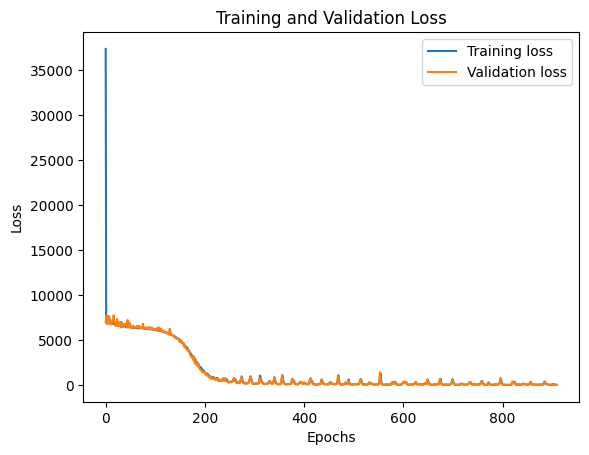

In [207]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "recurrent_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)
    
    # Recurrent neural network model architecture (LSTM)
    rnn_model = Sequential()
    rnn_model.add(LSTM(1000, activation="relu", input_shape=(x_train.shape[1], 1)))
    rnn_model.add(Dense(512, activation='relu'))
    rnn_model.add(Dense(64, activation='relu'))
    rnn_model.add(Dense(1, activation='linear'))
    
    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(rnn_model, 'rnn_model')
    
    rnn_model.summary()
    
    rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = rnn_model.fit(x_train_cnn, y_train, 
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val_cnn, y_val),
                            verbose=1)
    
    # Log metrics
    mlflow.log_metric('final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('final_validation_loss', history.history['val_loss'][-1])
    
    # Predictions
    train_preds = rnn_model.predict(x_train_cnn)
    val_preds = rnn_model.predict(x_val_cnn)
    test_preds = rnn_model.predict(x_test_cnn)
    
    # Evaluate on the test set
    rnn_results = rnn_model.evaluate(x_test_cnn, y_test)
    
        # MAE
    rnn_train_mae = mean_absolute_error(y_train, train_preds)
    rnn_val_mae = mean_absolute_error(y_val, val_preds)
    rnn_test_mae = rnn_results[1]
    
    # MSE
    rnn_train_mse = mean_squared_error(y_train, train_preds)
    rnn_val_mse = mean_squared_error(y_val, val_preds)
    rnn_test_mse = rnn_results[0]
    
    # RMSE
    rnn_train_rmse = np.sqrt(rnn_train_mse)
    rnn_val_rmse = np.sqrt(rnn_val_mse)
    rnn_test_rmse = np.sqrt(rnn_test_mse)
    
    # R-Square
    rnn_train_r2 = r2_score(y_train, train_preds)
    rnn_val_r2 = r2_score(y_val, val_preds)
    rnn_test_r2 = r2_score(y_test, test_preds)
    
    # MAPE
    rnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    rnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    rnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    
    # Logging metrics
    mlflow.log_metric('rnn_train_mae', rnn_train_mae)
    mlflow.log_metric('rnn_val_mae', rnn_val_mae)
    mlflow.log_metric('rnn_test_mae', rnn_test_mae)

    mlflow.log_metric('rnn_train_mse', rnn_train_mse)
    mlflow.log_metric('rnn_val_mse', rnn_val_mse)
    mlflow.log_metric('rnn_test_mse', rnn_test_mse)
    
    mlflow.log_metric("rnn_train_rmse", rnn_train_rmse)
    mlflow.log_metric("rnn_val_rmse", rnn_val_rmse)
    mlflow.log_metric("rnn_test_rmse", rnn_test_rmse)

    mlflow.log_metric("rnn_train_r2", rnn_train_r2)
    mlflow.log_metric("rnn_val_r2", rnn_val_r2)
    mlflow.log_metric("rnn_test_r2", rnn_test_r2)
    
    mlflow.log_metric("rnn_train_mape", rnn_train_mape)
    mlflow.log_metric("rnn_val_mape", rnn_val_mape)
    mlflow.log_metric("rnn_test_mape", rnn_test_mape)
    
    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    loss_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\rnn_loss_plot.png'

    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)
    
    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='red')

    # Tight layout
    fig.tight_layout()

    # Save scatter plot
    scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\rnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)
    plt.close()
    
    # Print results
    print("Training Results:")
    print("Train MAE:", rnn_train_mae)
    print("Train MSE:", rnn_train_mse)
    print("Train RMSE:", rnn_train_rmse)
    print("Train MAPE:", rnn_train_mape)
    print("Train R-squared:", rnn_train_r2)
    
    print(" ")
    print("Testing Results:")
    print("Test MAE:", rnn_test_mae)
    print("Test MSE:", rnn_test_mse)
    print("Test RMSE:", rnn_test_rmse)
    print("Test MAPE:", rnn_test_mape)
    print("Test R-squared:", rnn_test_r2)
    
    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\rnn_saved_model'
    rnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)
    mlflow.end_run()

### 4. Neural Network Ensemble 

161/161 [==============================] - 3s 16ms/step


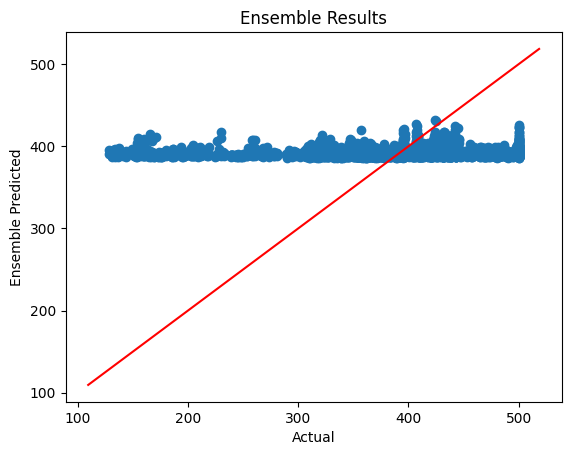

Ensemble Results:
Ensemble MAE: 60.3622
Ensemble MSE: 6405.2236
Ensemble RMSE: 80.03264
Ensemble R-squared: 0.0031601016525545367
Ensemble MAPE: 19.62656080722809


In [213]:
from sklearn.linear_model import LinearRegression
import joblib

# Starting MLflow run
with mlflow.start_run():
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "linear_neural_network_ensemble")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.log_param("Data-path", "D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data")
    
    
    # Load the saved models
    ffn_model = mlflow.tensorflow.load_model(f"runs:/0978b06d22804907a29098152dd0d4b2/ffn_model")
    cnn_model = mlflow.tensorflow.load_model(f"runs:/366da7d30c044099a18c432c567c2ff6/cnn_model")
    rnn_model = mlflow.tensorflow.load_model(f"runs:/2f1e5db010a849d097cc423663b136eb/rnn_model")

    # Make predictions using individual models
    ffn_preds = ffn_model.predict(x_test)
    cnn_preds = cnn_model.predict(x_test_cnn)
    rnn_preds = rnn_model.predict(x_test_cnn)

    # Combine predictions by averaging
    ensemble_preds = (ffn_preds + cnn_preds + rnn_preds) / 3

    # Create a simple linear regression model as the ensemble model
    ensemble_model = LinearRegression()

    # Train the ensemble model using the individual predictions as features
    ensemble_model.fit(np.hstack([ffn_preds, cnn_preds, rnn_preds]), y_test)

    # Make predictions using the ensemble model
    ensemble_preds = ensemble_model.predict(np.hstack([ffn_preds, cnn_preds, rnn_preds]))

    # Evaluate the performance of the ensemble model
    ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
    ensemble_mse = mean_squared_error(y_test, ensemble_preds)
    ensemble_rmse = np.sqrt(ensemble_mse)
    ensemble_r2 = r2_score(y_test, ensemble_preds)
    ensemble_mape = np.mean(np.abs((y_test - ensemble_preds) / y_test)) * 100

    mlflow.log_metric("ensemble_mae", ensemble_mae)
    mlflow.log_metric("ensemble_mse", ensemble_mse)
    mlflow.log_metric("ensemble_rmse", ensemble_rmse)
    mlflow.log_metric("ensemble_r2", ensemble_r2)
    mlflow.log_metric("ensemble_mape", ensemble_mape)

    # Plot and save the ensemble scatter plot
    plt.scatter(x=y_test, y=ensemble_preds)
    plt.xlabel("Actual", fontsize=10)
    plt.ylabel("Ensemble Predicted", fontsize=10)
    plt.title("Ensemble Results")

    x = np.linspace(*plt.xlim())
    plt.plot(x, x, color='red')

    # Save scatter plot
    ensemble_scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\ensemble_scatter_plot.png'
    plt.savefig(ensemble_scatter_plot_path)
    mlflow.log_artifact(ensemble_scatter_plot_path)
    plt.show()

    # Print ensemble results
    print("Ensemble Results:")
    print("Ensemble MAE:", ensemble_mae)
    print("Ensemble MSE:", ensemble_mse)
    print("Ensemble RMSE:", ensemble_rmse)
    print("Ensemble R-squared:", ensemble_r2)
    print("Ensemble MAPE:", ensemble_mape)

    # Saving the ensemble model as a pickle file 
    joblib.dump(ensemble_model, r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\ensemble_model.pkl')

    # Log the ensemble model as an artifact
    mlflow.log_artifact(r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\ensemble_model.pkl')
